Pedotransfer functions (PTFs) are predictive models used in soil science to estimate soil properties that are usually hard to measure directly. They are particularly valuable for predicting soil hydraulic properties such as field capacity, permanent wilting point, and available water capacity from more easily measured soil characteristics like soil texture, bulk density, and organic matter content. The PTFs developed by Rawls et al. (1982) and Saxton & Rawls (2006) use soil texture and organic matter as inputs to predict key soil hydraulic parameters and have become widely used in hydrological modeling, irrigation management, and soil physics due to their simplicity and minimal data requirements.


In [6]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
def ptf(clay, sand, om=0.02, ec=0, rho=np.nan):
    """ 
    Pedotransfer functions to determine soil physical properties from 
    soil texture and organic matter.

    Parameters:
    clay (interger, float): clay content
    sand (integer, float): sand content
    om (integer, float): Fraction of organic matter.

    Returns:
    Outputs: S is a dictionary containing scalar values.
             V is a Pandas dataframe containing vector values across the range from 1500 to 0 kPa.

    """ 


    # Section numbering does NOT follow the Saxton and Rawls paper
    # 1. Permanent wilting point
    # Calculation of soil water retention at -1500 kPa of tension (Table 1. Eq. 1)
    theta_1500t = -0.024*sand + 0.487*clay + 0.006*om + 0.005*(sand*om) - 0.013*(clay*om) + 0.068*(sand*clay) + 0.031 
    theta_1500 = theta_1500t + (0.14*theta_1500t - 0.02)

    # 2. Field capacity
    # Calculation of soil water retention at -33 kPa of tension (Table 1. Eq. 2)
    theta_33t= -0.251*sand + 0.195*clay + 0.011*om + 0.006*(sand*om) - 0.027*(clay*om) + 0.452*(sand*clay) + 0.299
    theta_33 = theta_33t + 1.283*(theta_33t)**2 - 0.374*(theta_33t) - 0.015

    # 3. Saturation-Field capacity.
    # Volumetric soil water content between 0 and -33 kPa of tension (Table 1. Eq. 3). 
    thetaS_33t= 0.278*sand + 0.034*clay + 0.022*om - 0.018*(sand*om) - 0.027*(clay*om) - 0.584*(sand*clay) + 0.078
    thetaS_33= thetaS_33t + (0.636*thetaS_33t - 0.107)

    # 4. Tension at air entry suction.
    # Estimation of the tension at air entry (Table 1. Eq. 4).
    psi_et = -21.67*sand - 27.93*clay - 81.97*thetaS_33 + 71.12*sand*thetaS_33 + 8.29*clay*thetaS_33 + 14.05*sand*clay + 27.16
    psi_e = max(psi_et + 0.02*psi_et**2 - 0.113*psi_et - 0.7,0.1) # A minimum air-entry suction of 1 kPa was assumed to avoid negative values in sandy soils. 

    # 5. Saturation.
    # Calculation of soil water retention at -0 kPa of tension (Table 1. Eq. 5)
    thetaS = theta_33 + thetaS_33 - 0.097*sand + 0.043 # Saturation at normal density

    # 6. Density effects (allow user to input of bulk density in case is known)
    if ~np.isnan(rho):
        rho_DF = rho
    else:
        rho_N = (1-thetaS)*2.65 # Particle density is assumed to be 2.65 g cm^-3. (Table 1. Eq. 6)
        DF = 1 # Compaction degree.
        rho_DF = rho_N*DF # (Table 1. Eq. 7).

    thetaS_DF = 1 - (rho_DF/2.65) # (Table 1. Eq. 8).
    theta_33_DF = theta_33 - 0.2*(thetaS-thetaS_DF) # (Table 1. Eq. 9).
    thetaS_33_DF = thetaS_DF - theta_33_DF; # (Table 1. Eq. 10).
    # thetaS_33_DF is used with equations that account for gravel, not present
    # in this version. For more information see Table 1 Eqs. 19-22 in Saxton and Rawls, 2006.

    # 7. Moisture tension
    B = (np.log(1500) - np.log(33))/(np.log(theta_33) - np.log(theta_1500)) # (Table 1. Eq. 15).
    A = np.exp(np.log(33) + B*np.log(theta_33)); # (Table 1. Eq. 14).

    # Generate points of volumetric water content.
    theta_piece1 = np.linspace(theta_1500, theta_33_DF, 1000) # theta from theta_1500 to theta_33
    theta_piece2 = np.linspace(theta_33_DF, thetaS_DF, 1000) # theta from theta_33 to theta_0

    # Generate soil matric potential values
    psi_piece1 = A*theta_piece1**(-B) # Matric potential from 1500 to 33 kPa (Table 1. Eq. 11). 
    psi_piece2 = 33 - ((theta_piece2 - theta_33)*(33 - psi_e)/(thetaS_DF - theta_33)) # Matric potential from 33 kPa to air-entry suction (Table 1. Eq. 12).

    # Merge water content and matric potential pieces to generate the soil water retention curve
    theta = np.concatenate((theta_piece1, theta_piece2, [thetaS_DF]))
    psi_m = np.concatenate((psi_piece1, psi_piece2, [0.1]))

    # 8. Calculate volumetric water content at 10 kPa (perhaps a better definition of field capacity)
    psi_diff10 = (psi_m - 10)**2;
    theta_10_DF = theta[psi_diff10.argmin(axis=0)]

    # 9. Moisture conductivity
    par_lambda = 1/B; # (Table 1. Eq. 18).
    Ks = 1930*(thetaS_DF - theta_33)**(3 - par_lambda) # (Table 1. Eq. 16) in [mm/h].
    K_theta = Ks*(theta/thetaS_DF)**(3 + (2/par_lambda)) # (Table 1. Eq. 17).

    # 10. Salinity effects
    psi_o = 36*ec # (Table 1. Eq. 23).
    psi_o_theta = thetaS/theta*psi_o # (Table 1. Eq. 24).

    # 11. Set outputs
    props = {'theta_sat': thetaS_DF, 'theta_10':theta_10_DF, 'theta_33':theta_33_DF, 
             'theta_1500':theta_1500, 'K_sat':Ks, 'psi_o':psi_o, 'rho':rho_DF,
             'theta':theta, 'psi_m':psi_m, 'psi_o':psi_o_theta, 'K_theta':K_theta}

    return props 



In [11]:
# Example inputs
clay = 0.34 # 34% clay
sand = 0.22 # 22% sand
om = 0.015  # 1.5% OM
ec = 0.075 # dS/m
rho_b = 1.5 # g/cm^3

# Call function
props = ptf(clay, sand, om, ec, rho_b)

print(props)

{'theta_sat': 0.4339622641509434, 'theta_10': 0.43279196976870016, 'theta_33': 0.3504534007323006, 'theta_1500': 0.20392632400000002, 'K_sat': 1.5160753706941434, 'psi_o': array([5.85295059, 5.84874389, 5.84454323, ..., 2.75093194, 2.75040204,
       2.75040204]), 'rho': 1.5, 'theta': array([0.20392632, 0.204073  , 0.20421967, ..., 0.43387867, 0.43396226,
       0.43396226]), 'psi_m': array([1.50000000e+03, 1.49248108e+03, 1.48500521e+03, ...,
       9.69247111e+00, 9.66865433e+00, 1.00000000e-01]), 'K_theta': array([4.09372980e-06, 4.14400991e-06, 4.19487078e-06, ...,
       1.51112465e+00, 1.51607537e+00, 1.51607537e+00])}


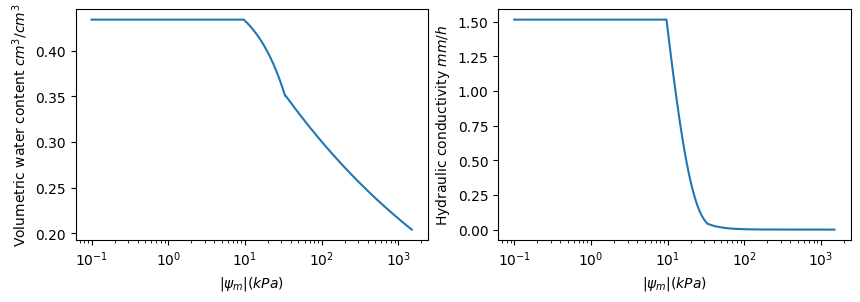

In [16]:
# Create figure to show properties
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title
plt.plot(props["psi_m"], props["theta"])
plt.xscale('log')
plt.xlabel("$|\psi_m| (kPa)$")
plt.ylabel("Volumetric water content $cm^3/cm^3$")

plt.subplot(1,2,2)
plt.title
plt.plot(props["psi_m"], props["K_theta"])
plt.xscale('log')
plt.xlabel("$|\psi_m| (kPa)$")
plt.ylabel("Hydraulic conductivity $mm/h$")
plt.show()


## References

Rawls, W.J., Brakensiek, D.L. and Saxton, K.E., 1982. Estimation of soil water properties. Transactions of the ASAE, 25(5), pp.1316-1320.
           
Saxton, K.E., Rawls, W., Romberger, J.S. and Papendick, R.I., 1986. Estimating generalized soil-water characteristics from texture 1. Soil science society of America Journal, 50(4), pp.1031-1036.

Saxton, K.E. and Rawls, W.J., 2006. Soil water characteristic estimates by texture and organic matter for hydrologic solutions. Soil science society of America Journal, 70(5), pp.1569-1578.